# full exp:
- gridsearch blocked/interleaved, using MSE human as eval metric
    - fix parameters
- eval fit on early/middle/late conditions

# handheld splitting, RNN schema

In [1]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
from scipy.stats import zscore
from utils import *

In [2]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
%matplotlib inline

### load human data for fitting

In [3]:
import pandas as pd
humandf = pd.read_csv('humandf.csv')
human_accD = {}
condL =['blocked','interleaved','early','middle','late']
for cond in condL:
    human_accD[cond] = humandf.loc[:,'%s mean'%cond].values
# 1d arrs of acc
human_accD['blocked'].shape,human_accD.keys()

((200,), dict_keys(['blocked', 'interleaved', 'early', 'middle', 'late']))

### experiment funs

In [4]:
def run_exp(nseeds,condL,paramD,ntr=160,nte=40):
    """ returns acc for cond in condL """
    print('N=%i'%nseeds,paramD)
    acc = -np.ones([len(condL),nseeds,ntr+nte])
    for ci,cond in enumerate(condL):
        for s in range(nseeds):
            # seed ctrl
            np.random.seed(s)
            tr.manual_seed(s)
            # init
            ag = Agent(**paramD)
            task = Task()
            # run
            exp,cur = task.generate_experiment(cond,ntr,nte)
            acc[ci,s] = ag.forward_exp(exp) 
    return acc

  
def calc_fit(accL,condL):
    """ 
    accL is arr [cond,seed,trials]
    NOTE: CURRENTLY FITTING ON ZSCORED
    calcualte mean squared error for model fit
    returns mse per condition
    """
    MSE = 0
    for model_acc,cond in zip(accL,condL):
        human_acc = human_accD[cond]
        # mean over seeds -> [trials]
        model_acc = model_acc.mean(0) 
        # zscore
        model_zacc = zscore(model_acc)
        human_zacc = zscore(human_acc)
        # mse
        MSE += np.sum((human_zacc - model_zacc)**2)
    return MSE


# gridsearch free params:

- sticky_decay_rate
- pe_thresh 
- init_lr 
- lr_decay_rate

In [5]:
nseeds = 20
condBI = ['blocked','interleaved']
# gridsearch
Sd = np.arange(0.03,0.031,0.005)
Pt = np.arange(0.9,0.91,0.1)
L0 = np.arange(0.35,0.351,0.05)
Ld = np.arange(0.15,0.151,0.05)
print(Sd,Pt,L0,Ld)

gs_results = []
for sd,pt,l0,ld in itertools.product(Sd,Pt,L0,Ld):
    paramD = {
      'sticky_decay':sd,
      'pe_thresh':pt,
      'init_lr':l0,
      'lr_decay':ld,
    }
    acc = run_exp(nseeds,condBI,paramD,ntr=160,nte=40)
    mse = calc_fit(acc,condBI)
    gs_results.append({**paramD,'mse':mse})
    
## get best fit
bestparamD = pd.DataFrame(gs_results
              ).sort_values('mse').iloc[0].to_dict()
bestparamD.pop('mse')
bestparamD

[0.03] [0.9] [0.35] [0.15]
N=1 {'sticky_decay': 0.03, 'pe_thresh': 0.9, 'init_lr': 0.35, 'lr_decay': 0.15}


{'sticky_decay': 0.03, 'pe_thresh': 0.9, 'init_lr': 0.35, 'lr_decay': 0.15}

# analysis of best fit

In [7]:
acc = run_exp(nseeds=20,
              condL=condBI,
              paramD=bestparamD
             )

N=1 {'sticky_decay': 0.03, 'pe_thresh': 0.9, 'init_lr': 0.35, 'lr_decay': 0.15}


### blocked / interleaved plots

In [13]:
def plt_human(ax=None,condL=['blocked'],c='k'):
  for cond in condL:
    ax.plot(human_accD[cond],
            c=c,zorder=-99,alpha=0.4
           )
  return None

def plt_acc(acc,condL,ax=None,h=1):
  # model
  for ac in acc:
    ax.plot(ac.mean(0))
  # human plot
  if h:
    plt_human(ax=ax,condL=condL)
  ax.set_ylim(0.2,1)    
  return None

In [ ]:
plt.subplots(figsize=(10,4))
ax = plt.gca()
plt_acc(acc,condBI,ax=ax)

### early / middle / late plots

In [12]:
condEML=['early','middle','late']
acc = run_exp(nseeds=10,
              condL=condEML,
              paramD=bestparamD
             )

N=10 {'sticky_decay': 0.03, 'pe_thresh': 0.9, 'init_lr': 0.35, 'lr_decay': 0.15}


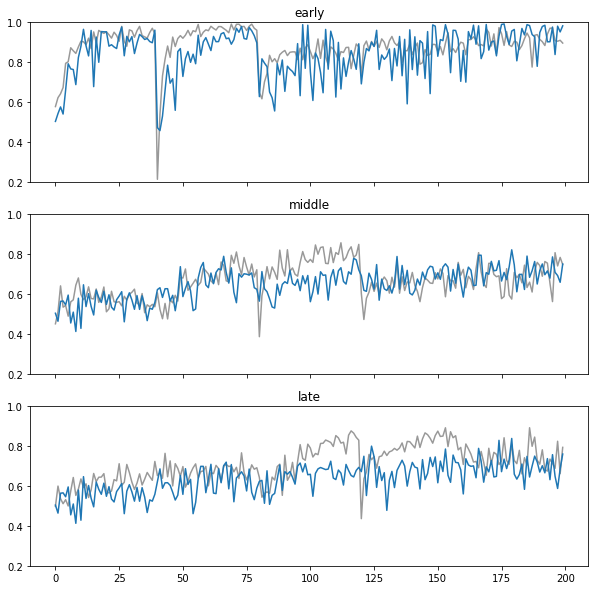

In [25]:
f,ax = plt.subplots(3,1,figsize=(10,10),sharex=True)
for ci in range(3):
  cond = condEML[ci]
  plt_acc([acc[ci]],[cond],ax=ax[ci])
  ax[ci].set_title(cond)